# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [1]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=4aea0722-5718-4f2f-91f5-a6af325cf43f
To: /content/HW2.zip
100% 52.1M/52.1M [00:00<00:00, 158MB/s]


#### Import packages

In [2]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torchsummary import summary
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [3]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 256,
    n_epoch = 50,
    lr = 2e-3,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [4]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

cuda


#### Dataset and Dataloader

In [5]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [6]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=30, scale=(0.90, 1.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
    T.ToTensor(),

])
eval_tfm = T.Compose([
    T.ToTensor(),
])

In [7]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

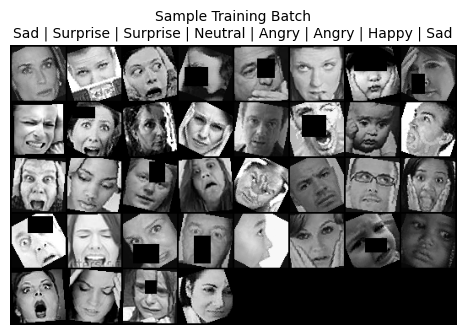

In [8]:
import matplotlib.pyplot as plt
import torchvision

def show_batch(images, labels, classes=None, nrow=8, title="Sample Training Batch"):
    """
    Visualize a batch of images from a DataLoader.

    Args:
        images (Tensor): Batch of images [B, C, H, W]
        labels (Tensor): Corresponding labels [B]
        classes (list, optional): Class names corresponding to label indices.
        nrow (int): Number of images per row in the grid.
        title (str): Title for the plot.
    """
    # Denormalize (if you used normalization in transforms)
    img = images.clone()
    select = [i for i, x in enumerate(labels.tolist()) if x == 2]
    img = img[select]


    # Make grid
    grid = torchvision.utils.make_grid(img, nrow=nrow, padding=2)
    plt.figure(figsize=(nrow * 0.72, nrow * 0.72))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")

    # Add labels below each image
    if classes is not None:
        label_texts = [classes[l.item()] if isinstance(l.item(), int) else str(l) for l in labels[:nrow]]
        plt.title(f"{title}\n" + " | ".join(label_texts), fontsize=10)
    else:
        plt.title(title)

    plt.show()

# Get a batch
images, labels = next(iter(train_loader))

# Define your class names (adjust to your dataset)
classes = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Visualize
show_batch(images, labels, classes=classes)

#### Model

In [9]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
          nn.Linear(512 * 4 * 4, 128),
          nn.ReLU(),
          nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 512 * 4 * 4)
        x = self.fc(x)
        return x

#### training loop

In [10]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

In [ ]:
model = FaceExpressionNet().to(device)
summary(model, (1, 64, 64))
train(model, train_loader, valid_loader, config)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         295,168
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
      BatchNorm2d-14            [-1, 51

100%|██████████| 91/91 [00:27<00:00,  3.34it/s]


Epoch: 1/50, train loss: 2.5850, train acc: 0.2342
Epoch: 1/50, valid loss: 1.8051, valid acc: 0.2478
== best valid acc: 0.2478 ==


100%|██████████| 91/91 [00:26<00:00,  3.38it/s]


Epoch: 2/50, train loss: 1.8042, train acc: 0.2530
Epoch: 2/50, valid loss: 1.8087, valid acc: 0.2423


100%|██████████| 91/91 [00:27<00:00,  3.31it/s]


Epoch: 3/50, train loss: 1.7983, train acc: 0.2539
Epoch: 3/50, valid loss: 1.8037, valid acc: 0.2487
== best valid acc: 0.2487 ==


100%|██████████| 91/91 [00:26<00:00,  3.43it/s]


Epoch: 4/50, train loss: 1.7899, train acc: 0.2574
Epoch: 4/50, valid loss: 1.7807, valid acc: 0.2624
== best valid acc: 0.2624 ==


100%|██████████| 91/91 [00:27<00:00,  3.37it/s]


Epoch: 5/50, train loss: 1.7441, train acc: 0.2861
Epoch: 5/50, valid loss: 1.6995, valid acc: 0.3073
== best valid acc: 0.3073 ==


100%|██████████| 91/91 [00:26<00:00,  3.43it/s]


Epoch: 6/50, train loss: 1.6517, train acc: 0.3367
Epoch: 6/50, valid loss: 1.6606, valid acc: 0.3240
== best valid acc: 0.3240 ==


100%|██████████| 91/91 [00:26<00:00,  3.41it/s]


Epoch: 7/50, train loss: 1.6003, train acc: 0.3623
Epoch: 7/50, valid loss: 1.6332, valid acc: 0.3440
== best valid acc: 0.3440 ==


100%|██████████| 91/91 [00:27<00:00,  3.37it/s]


Epoch: 8/50, train loss: 1.5466, train acc: 0.3792
Epoch: 8/50, valid loss: 1.5626, valid acc: 0.3644
== best valid acc: 0.3644 ==


100%|██████████| 91/91 [00:26<00:00,  3.43it/s]


Epoch: 9/50, train loss: 1.4987, train acc: 0.3973
Epoch: 9/50, valid loss: 1.5465, valid acc: 0.3698
== best valid acc: 0.3698 ==


 26%|██▋       | 24/91 [00:07<00:27,  2.41it/s]

In [ ]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

draw_confusion_matrix(model, valid_loader)


### Testing

In [ ]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [ ]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)